In [63]:
# munging imports
import pandas as pd
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modeling and performance imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# from sklearn import tree

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# Random Sampling
from imblearn.over_sampling import RandomOverSampler

# Load Dataset

In [2]:
rookie_yrs = pd.read_csv('rookie_yrs.csv', encoding='utf-8')
rookie_yrs.tail(5)

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FG%,3P%,...,TOV,STL,BLK,PF,DD2,TD3,+/-,SEASON,NUM_YRS,TARGET_4UP
2453,Anthony Miller,ATL,25,1,0,1,13.7,0,0.0,0.0,...,0,0,0,2,0,0,-14,1996-97,6,1
2454,Bruce Bowen,MIA,26,1,1,0,0.6,0,0.0,0.0,...,0,0,1,0,0,0,3,1996-97,13,1
2455,Cuonzo Martin,MIL,25,3,0,3,13.0,0,0.0,0.0,...,1,0,0,1,0,0,-2,1996-97,1,0
2456,Derrick Alston,ATL,24,2,1,1,10.6,0,0.0,0.0,...,0,0,0,0,0,0,-7,1996-97,1,0
2457,Elmore Spencer,SEA,27,1,1,0,5.5,0,0.0,0.0,...,1,1,0,0,0,0,-15,1996-97,1,0


# Partition Dataset

In [3]:
# With small dataset and to reduce variance, split with cross-validation in mind

"""
Drop string columns: 'SEASON', 'PLAYER', 'TEAM'.
Drop target column: 'TARGET_4UP'
Drop column 'NUM_YRS' used to make target column
"""

X = rookie_yrs.drop(columns=['PLAYER', 'TEAM', 'SEASON','TARGET_4UP', 'NUM_YRS']) 
y = rookie_yrs['TARGET_4UP']

# Use stratify to ensure minority class is included in both train/test set in 80:20 ratio each
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

# Use StratifyKFold to ensure that each fold has the same proportion of observations
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Scoring Method

In [4]:
"""
Create a function to score metrics using cross-validation.
Print out mean of all scores and include the spread of scores.
"""


def score_metrics(model, X_train, y_train):
    
    # cross_val_score will print an array of scores
    accuracy_score = cross_val_score(model, X_train, y_train,
                                 cv=kf, 
                                 scoring='accuracy')
    precision_score = cross_val_score(model, X_train, y_train,
                             cv=kf, 
                             scoring='precision')               
    recall_score = cross_val_score(model, X_train, y_train,
                             cv=kf, 
                             scoring='recall')  
    f1_score = cross_val_score(model, X_train, y_train,
                             cv=kf, 
                             scoring='f1')
    roc_auc_score = cross_val_score(model, X_train, y_train,
                             cv=kf, 
                             scoring='roc_auc')
    
    # Take the mean of each score set
    accuracy_mean = np.mean(accuracy_score)
    precision_mean = np.mean(precision_score)
    recall_mean = np.mean(recall_score)                                     
    f1_mean = np.mean(f1_score)
    roc_auc_mean = np.mean(roc_auc_score)
    
    # Print mean scores and their spread
    print(f"Accuracy: {np.mean(accuracy_score):.3f} +- {np.std(accuracy_score):.3f}")
    print(f"Precision: {np.mean(precision_score):.3f} +- {np.std(precision_score):.3f}")
    print(f"Recall: {np.mean(recall_score):.3f} +- {np.std(recall_score):.3f}")
    print(f"F1: {np.mean(f1_score):.3f} +- {np.std(f1_score):.3f}")
    print(f"ROC-AUC: {np.mean(roc_auc_score):.3f} +- {np.std(roc_auc_score):.3f}")

# Baseline Models

In [5]:
"""
Build baseline models at default settings, no hyperparameter tuning.
"""

lr = LogisticRegression() 
knn = KNeighborsClassifier(n_neighbors=10)
nb = GaussianNB()
clf = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier()
xgb = XGBClassifier(use_label_encoder=False )

# Summary of Baseline Scores
### Without Hyperparameter Tuning

In [24]:
print("Summary of Baseline Scores: ")

print('\n')

# Logistic Regression with 1-Feature Input
print("Logistic regression (1-F) mean scores: ")
lr1f_scores = score_metrics(model=lr, X_train=X_train[['MIN']], y_train=y_train)

print('\n')

# Logistic Regression with 3-Feature Input
# Scale features
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train[['MIN', 'GP', 'PTS']])

print("Logistic regression (3-F) mean scores: ")
lr3f_scores = score_metrics(model=lr, X_train=X_train_scaled, y_train=y_train)

print('\n')

# Logistic Regression with ALL-Feature Input
# Scale features
std_scale = StandardScaler()
X_train_all_scaled = std_scale.fit_transform(X_train)

print("Logistic regression (all-F) mean scores: ")
lr_all_scores = score_metrics(model=lr, X_train=X_train_all_scaled, y_train=y_train)

print('\n')

# kNN
print("kNN mean scores: ")
knn_scores = score_metrics(model=knn, X_train=X_train, y_train=y_train)

print('\n')

# Gaussian NB
print("Gaussian NB (3-F) mean scores: ")
gaussiannb_scores = score_metrics(model=nb, X_train=X_train[['MIN', 'GP', 'PTS']], y_train=y_train)

print('\n')

print("Gaussian NB (all-F) mean scores: ")
gaussiannb_all_scores = score_metrics(model=nb, X_train=X_train, y_train=y_train)

print('\n')

# Decision Tree
print("Decision Tree mean scores: ")
decision_tree_scores = score_metrics(model=clf, X_train=X_train, y_train=y_train)

print('\n')

# Random Forest
print("Random Forest mean scores: ")
random_forest_scores = score_metrics(model=rf, X_train=X_train, y_train=y_train)

print('\n')

# XGBoost
print("XGBoost mean scores: ")
xgboost_scores = score_metrics(model=xgb, X_train=X_train, y_train=y_train)

Summary of Baseline Scores: 


Logistic regression (1-F) mean scores: 
Accuracy: 0.733 +- 0.009
Precision: 0.739 +- 0.024
Recall: 0.551 +- 0.018
F1: 0.631 +- 0.011
ROC-AUC: 0.789 +- 0.005


Logistic regression (3-F) mean scores: 
Accuracy: 0.742 +- 0.012
Precision: 0.711 +- 0.021
Recall: 0.635 +- 0.023
F1: 0.670 +- 0.016
ROC-AUC: 0.796 +- 0.004


Logistic regression (all-F) mean scores: 
Accuracy: 0.753 +- 0.013
Precision: 0.735 +- 0.022
Recall: 0.632 +- 0.034
F1: 0.679 +- 0.019
ROC-AUC: 0.821 +- 0.009


kNN mean scores: 
Accuracy: 0.732 +- 0.016
Precision: 0.715 +- 0.019
Recall: 0.584 +- 0.038
F1: 0.643 +- 0.029
ROC-AUC: 0.778 +- 0.013


Gaussian NB (3-F) mean scores: 
Accuracy: 0.735 +- 0.014
Precision: 0.728 +- 0.025
Recall: 0.574 +- 0.035
F1: 0.641 +- 0.024
ROC-AUC: 0.793 +- 0.005


Gaussian NB (all-F) mean scores: 
Accuracy: 0.740 +- 0.014
Precision: 0.745 +- 0.020
Recall: 0.562 +- 0.031
F1: 0.641 +- 0.025
ROC-AUC: 0.799 +- 0.006


Decision Tree mean scores: 
Accuracy: 0.652 +- 0.

**The baseline model with the highest F1 score: Logistic Regression with all-Features.**

### A Glance at Feature Importance

In [47]:
# Let's take a look at the feature importance score provided by the random forest model
# First, fit the model
rf.fit(X_train, y_train)

# Feature coefficient results
list(zip(X_train.columns, rf.feature_importances_))

[('AGE', 0.0488307386422859),
 ('GP', 0.09998928531569654),
 ('W', 0.052701402908435946),
 ('L', 0.036800525040549266),
 ('MIN', 0.07101035060656923),
 ('PTS', 0.07146735936454233),
 ('FG%', 0.04638381203447719),
 ('3P%', 0.030814820465917065),
 ('FT%', 0.041019359853341535),
 ('OREB', 0.06082022861167745),
 ('DREB', 0.07322439857912888),
 ('REB', 0.06770322239802432),
 ('AST', 0.04183752291147921),
 ('TOV', 0.04827974513983178),
 ('STL', 0.043170169764091035),
 ('BLK', 0.034512891540223696),
 ('PF', 0.06457548778682294),
 ('DD2', 0.014537456217598653),
 ('TD3', 0.0022643043028582124),
 ('+/-', 0.05005691851644903)]

Text(0, 0.5, 'Coefficients')

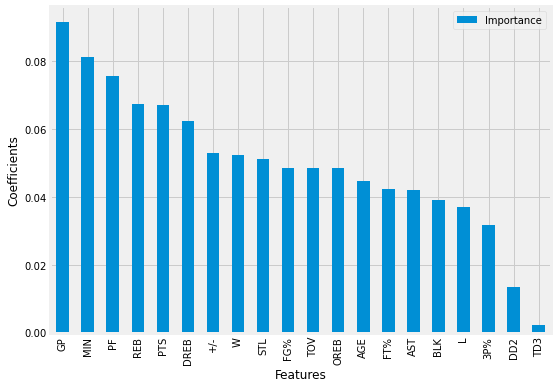

In [94]:
# Then, plot the features importances to see how they compare to each other
# Note: feature importance how tells us how they relate to each other, not WHY they are important
feat_importances = pd.DataFrame(rf.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))
plt.xlabel('Features')
plt.ylabel('Coefficients')

**Using Random Forest, we see that the most important feature is GP (Games Played), followed by MIN (Minutes Played) and PF (Personal Fouls).**

# Treating Class Imbalance

Let's see if we can improve our scores by addressing our class imbalance. Recall that during the EDA stage, we found the ratio of 1's:0's to be ~ 0.41/0.59.

In [6]:
"""
The dataset has ~ 40/60 split of class distribution, with the 40% being the target class.  
Let's try resampling our dataset to see if we could get higher scores on our metrics.
"""
print('Shape of X_train before oversampling: ', X_train.shape)
print('Shape of y_train before oversampling: ', y_train.shape)
print('\n')

# Randomly oversample positives
ros = RandomOverSampler(random_state=42)

X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print('Shape of X_train after oversampling: ', X_train_ros.shape)
print('Shape of y_train after oversampling: ', y_train_ros.shape)

Shape of X_train before oversampling:  (1966, 20)
Shape of y_train before oversampling:  (1966,)


Shape of X_train after oversampling:  (2306, 20)
Shape of y_train after oversampling:  (2306,)


**Now, the two class distributions are balanced. Try running the models using the balanced distributions and compare scores.**

### Summary of Scores After Resampling

In [25]:
print("Summary of Resampled Dataset Scores: ")

print('\n')

# Logistic Regression with ALL-Feature Input
# Scale features
X_train_all_ros_scaled = std_scale.fit_transform(X_train_ros)

print("Logistic regression (all-F) mean scores: ")
score_metrics(model=lr, X_train=X_train_all_ros_scaled, y_train=y_train_ros)

print('\n')

# kNN
print("kNN mean scores: ")
score_metrics(model=knn, X_train=X_train_ros, y_train=y_train_ros)

print('\n')

print("Gaussian NB (all-F) mean scores: ")
score_metrics(model=nb, X_train=X_train_ros, y_train=y_train_ros)

print('\n')

# Decision Tree
print("Decision Tree mean scores: ")
score_metrics(model=clf, X_train=X_train_ros, y_train=y_train_ros)

print('\n')

# Random Forest
print("Random Forest mean scores: ")
score_metrics(model=rf, X_train=X_train_ros, y_train=y_train_ros)

print('\n')

print("XGBoost mean scores: ")
score_metrics(model=xgb, X_train=X_train_ros, y_train=y_train_ros)

Summary of Resampled Dataset Scores: 


Logistic regression (all-F) mean scores: 
Accuracy: 0.742 +- 0.014
Precision: 0.754 +- 0.019
Recall: 0.718 +- 0.019
F1: 0.735 +- 0.014
ROC-AUC: 0.829 +- 0.009


kNN mean scores: 
Accuracy: 0.724 +- 0.008
Precision: 0.748 +- 0.007
Recall: 0.676 +- 0.019
F1: 0.710 +- 0.011
ROC-AUC: 0.792 +- 0.007


Gaussian NB (all-F) mean scores: 
Accuracy: 0.722 +- 0.020
Precision: 0.807 +- 0.020
Recall: 0.585 +- 0.032
F1: 0.678 +- 0.027
ROC-AUC: 0.806 +- 0.016


Decision Tree mean scores: 
Accuracy: 0.746 +- 0.015
Precision: 0.727 +- 0.019
Recall: 0.789 +- 0.025
F1: 0.756 +- 0.014
ROC-AUC: 0.746 +- 0.015


Random Forest mean scores: 
Accuracy: 0.807 +- 0.006
Precision: 0.812 +- 0.021
Recall: 0.818 +- 0.017
F1: 0.818 +- 0.018
ROC-AUC: 0.892 +- 0.009


XGBoost mean scores: 
Accuracy: 0.800 +- 0.025
Precision: 0.787 +- 0.037
Recall: 0.825 +- 0.006
F1: 0.805 +- 0.021
ROC-AUC: 0.876 +- 0.013


**In general, we see our scores improve across the board! Especially so, for Random Forest and XGBoost.  Let's see if we can improve the scores further with more feature engineering.**

# Feature Engineering

C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

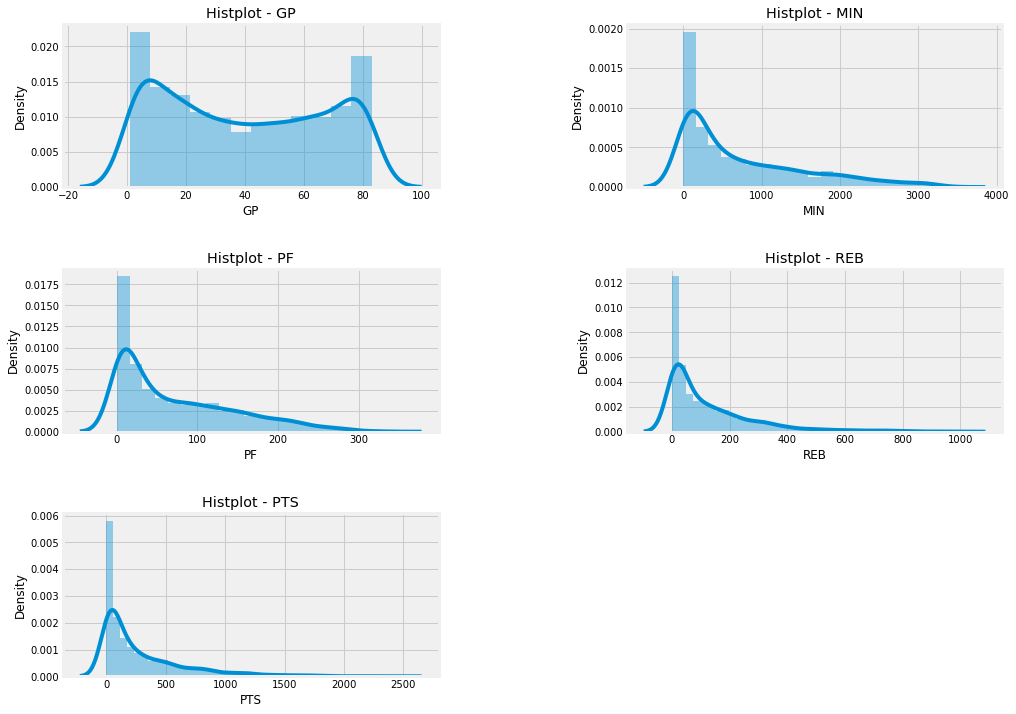

In [99]:
# Unfortunately, most of the features do not exhibit normal distribution.  
# This violates Gaussian assumption of normal distribution.  
# Here are the top 5 feature distribution plots.

from matplotlib.gridspec import GridSpec

gs = GridSpec(3,2)
gs.update(wspace = 0.5, hspace = 0.5)
fig = plt.figure(figsize=([15,12]), constrained_layout=True)

# GP
ax=plt.subplot(gs[0,0])
ax=sns.distplot(rookie_yrs['GP'])
plt.title('Histplot - GP')

# MIN
ax1=plt.subplot(gs[0,1])
ax1=sns.distplot(rookie_yrs['MIN'])
plt.title('Histplot - MIN')

# PF
ax2=plt.subplot(gs[1,0])
ax2=sns.distplot(rookie_yrs['PF'])
plt.title('Histplot - PF')

# REB
ax3=plt.subplot(gs[1,1])
ax3=sns.distplot(rookie_yrs['REB'])
plt.title('Histplot - REB')

# PTS
ax4=plt.subplot(gs[2,0])
ax4=sns.distplot(rookie_yrs['PTS'])
plt.title('Histplot - PTS')

plt.show()

### Log Transformation

**Let's try a Log Transformation of the top 5 features, based on the feature importance chart from Random Forest, to see if this will fix the problem.**

In [23]:
rookie_yrs['log_GP'] = np.log(rookie_yrs['GP'] + 0.0001) # avoid zero error for log transformation
rookie_yrs['log_PF']= np.log(rookie_yrs['PF'] + 0.0001)
rookie_yrs['log_MIN'] = np.log(rookie_yrs['MIN'] + 0.0001)
rookie_yrs['log_PTS'] = np.log(rookie_yrs['PTS'] + 0.0001)
rookie_yrs['log_REB'] = np.log(rookie_yrs['REB'] + 0.0001)

C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexib

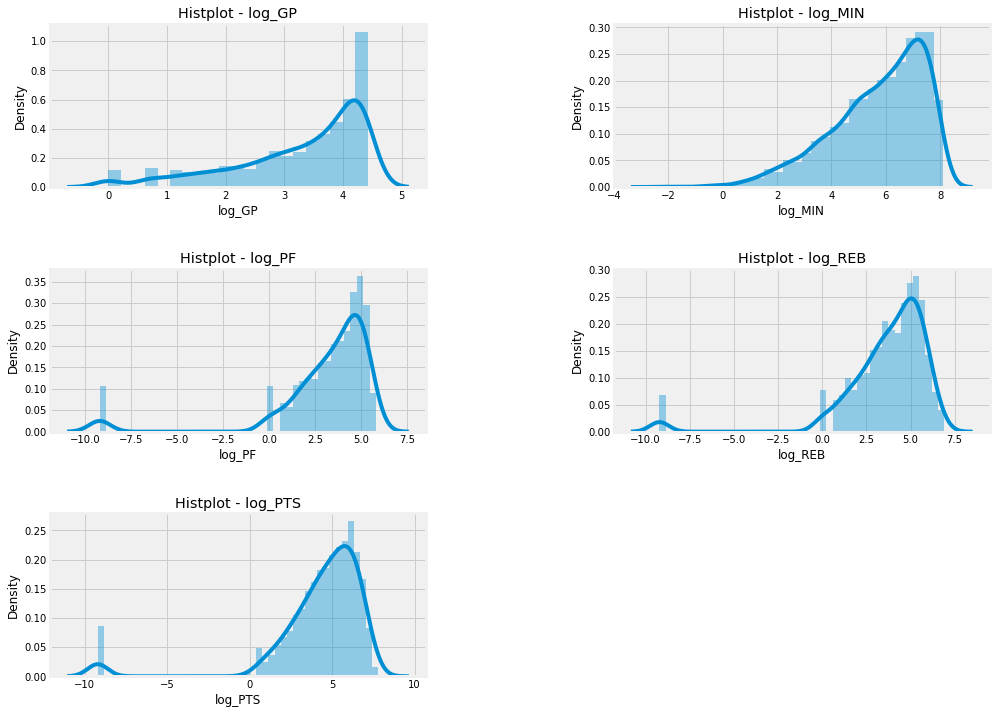

In [108]:
# A look at the distribution of the features after log transformation
from matplotlib.gridspec import GridSpec

gs = GridSpec(3,2)
gs.update(wspace = 0.5, hspace = 0.5)
fig = plt.figure(figsize=([15,12]), constrained_layout=True)

# GP
ax=plt.subplot(gs[0,0])
ax=sns.distplot(rookie_yrs['log_GP'])
plt.title('Histplot - log_GP')

# MIN
ax1=plt.subplot(gs[0,1])
ax1=sns.distplot(rookie_yrs['log_MIN'])
plt.title('Histplot - log_MIN')

# PF
ax2=plt.subplot(gs[1,0])
ax2=sns.distplot(rookie_yrs['log_PF'])
plt.title('Histplot - log_PF')

# REB
ax3=plt.subplot(gs[1,1])
ax3=sns.distplot(rookie_yrs['log_REB'])
plt.title('Histplot - log_REB')

# PTS
ax4=plt.subplot(gs[2,0])
ax4=sns.distplot(rookie_yrs['log_PTS'])
plt.title('Histplot - log_PTS')

plt.show()

**Unfortunately, our previously left skewed distributions are very right skewed now.  Let's see if our scores benefit from the transformation.**

In [24]:
# Use the log transformed features
log_X = rookie_yrs.drop(columns=['PLAYER', 'TEAM', 'SEASON','TARGET_4UP', 
                                 'NUM_YRS', 'GP', 'PF', 'MIN', 'PTS', 'REB']) 
y = rookie_yrs['TARGET_4UP']

# Partition dataset
log_X_train, log_X_test, y_train, y_test = train_test_split(log_X, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [9]:
log_X_train.head()

,AGE,W,L,FG%,3P%,FT%,OREB,DREB,AST,TOV,STL,BLK,DD2,TD3,+/-,log_GP,log_PF,log_MIN,log_PTS,log_REB
511,23,2,19,28.9,28.9,66.7,2,37,13,10,10,2,0,0,-75,3.044527,2.833219,5.489764,4.143136,3.663564
459,19,28,50,36.4,31.8,72.1,37,140,250,131,65,18,1,0,-100,4.356710,5.198498,7.441672,6.137727,5.176150
404,24,5,10,29.4,12.5,70.0,4,27,8,6,4,1,0,0,20,2.708057,2.397904,5.160779,3.663564,3.433990
1761,28,4,39,39.4,0.0,75.8,37,85,31,38,7,19,0,0,-197,3.761202,4.553878,6.395429,4.634730,4.804022
1855,24,4,1,33.3,0.0,0.0,3,4,0,3,1,0,0,0,-2,1.609458,1.609458,3.569536,1.791776,1.945924


In [25]:
# Resample our log transformed dataset
# Randomly oversample positives
ros = RandomOverSampler(random_state=42)

log_X_train_ros, y_train_ros = ros.fit_resample(log_X_train, y_train)

In [26]:
# Score with log transformed features + resampled dataset
print("Summary of Log-Transformed Features + Resampled Dataset Scores: ")

print('\n')

# Logistic Regression with ALL-Feature Input
# Scale features
log_X_train_ros_scaled = std_scale.fit_transform(log_X_train_ros)

print("Logistic regression (all-F) mean scores: ")
score_metrics(model=lr, X_train=log_X_train_ros_scaled, y_train=y_train_ros)

print('\n')

# kNN
print("kNN mean scores: ")
score_metrics(model=knn, X_train=log_X_train_ros, y_train=y_train_ros)

print('\n')

print("Gaussian NB (all-F) mean scores: ")
score_metrics(model=nb, X_train=log_X_train_ros, y_train=y_train_ros)

print('\n')

# Decision Tree
print("Decision Tree mean scores: ")
score_metrics(model=clf, X_train=log_X_train_ros, y_train=y_train_ros)

print('\n')

# Random Forest
print("Random Forest mean scores: ")
score_metrics(model=rf, X_train=log_X_train_ros, y_train=y_train_ros)

print('\n')

print("XGBoost mean scores: ")
score_metrics(model=xgb, X_train=log_X_train_ros, y_train=y_train_ros)

Summary of Log-Transformed Features + Resampled Dataset Scores: 


Logistic regression (all-F) mean scores: 
Accuracy: 0.744 +- 0.011
Precision: 0.755 +- 0.018
Recall: 0.722 +- 0.021
F1: 0.738 +- 0.011
ROC-AUC: 0.826 +- 0.008


kNN mean scores: 
Accuracy: 0.713 +- 0.014
Precision: 0.749 +- 0.023
Recall: 0.641 +- 0.012
F1: 0.691 +- 0.013
ROC-AUC: 0.783 +- 0.008


Gaussian NB (all-F) mean scores: 
Accuracy: 0.735 +- 0.014
Precision: 0.759 +- 0.013
Recall: 0.690 +- 0.026
F1: 0.723 +- 0.017
ROC-AUC: 0.806 +- 0.016


Decision Tree mean scores: 
Accuracy: 0.742 +- 0.001
Precision: 0.723 +- 0.003
Recall: 0.786 +- 0.007
F1: 0.753 +- 0.002
ROC-AUC: 0.742 +- 0.001


Random Forest mean scores: 
Accuracy: 0.813 +- 0.020
Precision: 0.800 +- 0.021
Recall: 0.818 +- 0.014
F1: 0.814 +- 0.012
ROC-AUC: 0.891 +- 0.008


XGBoost mean scores: 
Accuracy: 0.803 +- 0.025
Precision: 0.791 +- 0.037
Recall: 0.826 +- 0.003
F1: 0.808 +- 0.020
ROC-AUC: 0.875 +- 0.013


**After log transformation of the features, we would expect for the Gaussian NB and/or logistic regression models to benefit the most, as they are predicated on normal distribution of their features.**

In [17]:
print("Gaussian NB mean scores - Resampled w/o Log Transformation: ")
score_metrics(model=nb, X_train=X_train_ros, y_train=y_train_ros)
print('\n')
print("Gaussian NB mean scores - Resampled w Log Transformation: ")
score_metrics(model=nb, X_train=log_X_train_ros, y_train=y_train_ros)

Gaussian NB mean scores - Resampled w/o Log Transformation: 
Accuracy: 0.722 +- 0.020
Precision: 0.807 +- 0.020
Recall: 0.585 +- 0.032
F1: 0.678 +- 0.027
ROC-AUC: 0.806 +- 0.016


Gaussian NB mean scores - Resampled w Log Transformation: 
Accuracy: 0.735 +- 0.014
Precision: 0.759 +- 0.013
Recall: 0.690 +- 0.026
F1: 0.723 +- 0.017
ROC-AUC: 0.806 +- 0.016


**Although there is a sacrifice in precision, the recall and F1 scores both rose nicely in the Gaussian models!**

In [117]:
print("Logistic regression mean scores - Resampled w/o Log Transformation: ")
score_metrics(model=lr, X_train=X_train_all_ros_scaled, y_train=y_train_ros)
print('\n')
print("Logistic regression mean scores - Resampled w Log Transformation: ")
score_metrics(model=lr, X_train=log_X_train_ros_scaled, y_train=y_train_ros)

Logistic regression mean scores - Resampled w/o Log Transformation: 
Accuracy: 0.742 +- 0.014
Precision: 0.754 +- 0.019
Recall: 0.718 +- 0.019
F1: 0.735 +- 0.014
ROC-AUC: 0.829 +- 0.009


Logistic regression mean scores - Resampled w Log Transformation: 
Accuracy: 0.744 +- 0.011
Precision: 0.755 +- 0.018
Recall: 0.722 +- 0.021
F1: 0.738 +- 0.011
ROC-AUC: 0.826 +- 0.008


**As for logistic regression, there wasn't much benefit from the log transformation of the features.**

# Tuning Hyperparameters

So far, our highest scores come from the **Random Forest** model.  Log-transformation of features didn't do much for this model; in contrast, the F1 score decreased slightly.  We could choose to omit the log transformation if we are going to designate Random Forest as our final model.  Let's focus on tuning the hyperparameters to find the optimal values that will maximize performance, minimize loss, and eliminate the overfitting for Random Forest.

In [158]:
# Baseline
print("Random Forest Baseline mean scores: ")
random_forest_scores = score_metrics(model=rf, X_train=X_train, y_train=y_train)

print('\n')

# Random Forest
print("Random Forest (Resampled) mean scores: ")
score_metrics(model=rf, X_train=X_train_ros, y_train=y_train_ros)

print('\n')

# Log-Transformed, resampled
print("Random Forest (Log-Transformed, Resampled) mean scores: ")
score_metrics(model=rf, X_train=log_X_train_ros, y_train=y_train_ros)

Random Forest Baseline mean scores: 
Accuracy: 0.739 +- 0.015
Precision: 0.725 +- 0.031
Recall: 0.622 +- 0.035
F1: 0.662 +- 0.019
ROC-AUC: 0.808 +- 0.004


Random Forest (Resampled) mean scores: 
Accuracy: 0.812 +- 0.014
Precision: 0.802 +- 0.025
Recall: 0.821 +- 0.019
F1: 0.816 +- 0.012
ROC-AUC: 0.893 +- 0.009


Random Forest (Log-Transformed, Resampled) mean scores: 
Accuracy: 0.810 +- 0.017
Precision: 0.808 +- 0.015
Recall: 0.822 +- 0.014
F1: 0.814 +- 0.017
ROC-AUC: 0.892 +- 0.010


**We'll first use RandomisedSearchCV to find the best set of parameters by randomly selecting from a pre-defined grid.  Then we will use GridSearchCV to narrow down on the range to search for the perfect hyperparameters.**

In [10]:
"""
Try out a wide range of values and see what works
"""

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
# Min number of samples required to split a node
min_samples_split= [2,5,10]
# Min number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Used to meature quality of splits
criterion = ['gini', 'entropy']

# Create random grid
random_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap,
              'criterion': criterion}

In [11]:
# Instantiate the model
rf = RandomForestClassifier()

rf_random_search = RandomizedSearchCV(estimator=rf, 
                                   param_distributions=random_grid, 
                                   cv=5,
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1, 
                                     scoring='f1')

In [12]:
rf_random_search.fit(X_train_ros, y_train_ros) # No log transformation of features

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='f1', verbose=2)

In [13]:
# Best parameters from random search, no log transformation
rf_random_search.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 80,
 'criterion': 'entropy',
 'bootstrap': True}

In [14]:
# Best F1 score (RandomizedSearch), no log transformation
print("Best F1 score (no log): ", rf_random_search.best_score_)

Best F1 score (no log):  0.8044607572703695


In [32]:
rf_random_search.fit(log_X_train_ros, y_train_ros) # Log transformation of features 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\sandr\anaconda3\envs\metis\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='f1', verbose=2)

In [33]:
# Best parameters from random search, log-transformed
rf_random_search.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 80,
 'criterion': 'gini',
 'bootstrap': False}

In [34]:
# Best F1 score (RandomizedSearch), log transformation
print("Best F1 score: ", rf_random_search.best_score_)

Best F1 score:  0.80515298499471


**Since F1 scores with and without log transformation of features are insignificantly different, we'll choose not to include the log-transformed features to simplify the model.  Now, let's concentrate our search using GridSearchCV.**

In [16]:
# Create parameter grid based on results of random search
gs_n_estimators = [int(x) for x in np.linspace(start=1700, stop=1900, num=10)]
gs_min_samples_split= [2,5,10]
gs_min_samples_leaf = [1, 2]
gs_max_depth = [70, 80, 90]
gs_bootstrap = [True]
# gs_criterion = ['gini', 'entropy']

gs_grid = {'n_estimators': gs_n_estimators,
              'max_depth': gs_max_depth,
               'min_samples_split': gs_min_samples_split,
              'min_samples_leaf': gs_min_samples_leaf,
              'bootstrap': gs_bootstrap}
#               'criterion': gs_criterion}

In [17]:
# Instantiate the model
rf = RandomForestClassifier()

rf_grid_search = GridSearchCV(estimator=rf, 
                              param_grid=gs_grid, 
                              cv=5,
                              verbose=2,  
                              n_jobs=-1, 
                              scoring='f1')

In [18]:
rf_grid_search.fit(X_train_ros, y_train_ros) # no log transformation

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [70, 80, 90],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [1700, 1722, 1744, 1766, 1788, 1811,
                                          1833, 1855, 1877, 1900]},
             scoring='f1', verbose=2)

In [19]:
# Best parameters from grid search
rf_grid_search.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1877}

In [20]:
# Best F1 score (GridSearch)
rf_grid_search.best_score_

0.8099723047312247

In [82]:
# F1 Scores
print("Random Forest F1 Scores: ")

print('\n')

baseline_f1 = np.mean(cross_val_score(rf, X_train, y_train, cv=kf, scoring='f1'))
print("Baseline: ", np.round(baseline_f1, 4))
ros_f1 = np.mean(cross_val_score(rf, X_train_ros, y_train_ros, cv=kf, scoring='f1'))
print("Resampled: ", np.round(ros_f1, 4))
log_ros_f1 = np.mean(cross_val_score(rf, log_X_train_ros, y_train_ros, cv=kf, scoring='f1'))
print("Log-Transformed, Resampled: ", np.round(log_ros_f1, 4))
print("RandomSearchCV: ", np.round(rf_random_search.best_score_, 4))
print("GridSearchCV: ", np.round(rf_grid_search.best_score_, 4))

Random Forest F1 Scores: 


Baseline:  0.6701
Resampled:  0.8118
Log-Transformed, Resampled:  0.812
RandomSearchCV:  0.8045
GridSearchCV:  0.81


# Feature Selection

One last thing before we test on our test data.  Let's see if we can reduce the number of features by doing feature selection.  This will optimize our model's efficiency.

In [30]:
rf_feat_selection_model = SelectFromModel(RandomForestClassifier(bootstrap=True,
                                                 max_depth=70,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 n_estimators=1877,
                                                 random_state=42))
rf_feat_selection_model.fit(X_train_ros, y_train_ros)

SelectFromModel(estimator=RandomForestClassifier(max_depth=70,
                                                 n_estimators=1877,
                                                 random_state=42))

In [31]:
# Features selected as important
selected_features = X_train_ros.columns[(rf_feat_selection_model.get_support())]
selected_features

Index(['AGE', 'GP', 'W', 'MIN', 'PTS', 'OREB', 'DREB', 'REB', 'TOV', 'PF',
       '+/-'],
      dtype='object')

In [32]:
# Original list of features
original_features = X_train_ros.columns
original_features

Index(['AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FG%', '3P%', 'FT%', 'OREB',
       'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'DD2', 'TD3', '+/-'],
      dtype='object')

In [33]:
print("The model selected", len(selected_features), "out of", len(original_features), "features as being important to prediction.")

The model selected 11 out of 20 features as being important to prediction.


### Retrain with only selected features

In [36]:
# Retrain with only selected_features
X_sel_feat = rookie_yrs.drop(columns=['PLAYER', 'TEAM', 'SEASON','TARGET_4UP', 
                                 'NUM_YRS', 'L', 'FG%', '3P%', 'FT%', 'AST', 
                                      'STL', 'BLK', 'DD2', 'TD3', 'log_GP', 
                                      'log_PF', 'log_MIN', 'log_PTS', 'log_REB']) 
y = rookie_yrs['TARGET_4UP']

# Partition dataset
X_train_sel_feat, X_test_sel_feat, y_train, y_test = train_test_split(X_sel_feat, y, test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)

In [38]:
X_sel_feat.head()

,AGE,GP,W,MIN,PTS,OREB,DREB,REB,TOV,PF,+/-
0,20,79,21,2429.0,1197,84,272,356,119,164,-244
1,20,67,12,2137.7,1157,33,193,226,135,103,-519
2,20,74,43,2617.3,1134,195,362,557,136,192,66
3,20,64,20,2088.1,1114,58,296,354,234,200,-275
4,21,69,40,2331.0,1034,143,427,570,133,147,95


In [39]:
# Resample our dataset
# Randomly oversample positives
ros = RandomOverSampler(random_state=42)

X_train_sel_feat_ros, y_train_ros = ros.fit_resample(X_train_sel_feat, y_train)

In [40]:
# Instantitate model
rf_new = RandomForestClassifier(bootstrap=True,
                                max_depth=70,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=1877,
                                random_state=42)

rf_new.fit(X_train_sel_feat_ros, y_train_ros)

RandomForestClassifier(max_depth=70, n_estimators=1877, random_state=42)

In [41]:
# Mean F1 scores using selected features only
sel_feat_f1 = np.mean(cross_val_score(rf_new, X_train_sel_feat_ros, y_train_ros, cv=kf, scoring='f1'))

In [42]:
print("Before feature selection F1: ", np.round(rf_grid_search.best_score_, 4))
print("After feature selection F1: ", np.round(sel_feat_f1, 3))

Before feature selection F1:  0.81
After feature selection F1:  0.817


**Not a significant difference.  However, reducing the number of features helps to optimize the efficiency of our model and reduces overfitting.**

# Get Final Score on Test Set
### Chosen model: Random Forest - with feature reduction and optimized hyperparameters

### Comparing Training and Test Scores and What They Mean
    Tr = Te (low) -- underfit
    Tr = Te (high) -- good fit
    Tr > Te -- overfit
    Tr < Te -- outliers

In [48]:
# Test set
y_test_final = y_test
X_test_final = X_test_sel_feat

# Instantiate our model with optimized hyperparameters
final_model = RandomForestClassifier(bootstrap=True,
                                max_depth=70,
                                min_samples_leaf=1,
                                min_samples_split=2,
                                n_estimators=1877,
                                random_state=42)
final_model.fit(X_train_sel_feat_ros, y_train_ros)

RandomForestClassifier(max_depth=70, n_estimators=1877, random_state=42)

In [83]:
# Pickle test set
with open('y_test_final.pickle', 'wb') as to_write:
    pickle.dump(y_test_final, to_write)
    
with open('X_test_final.pickle', 'wb') as to_write:
    pickle.dump(X_test_final, to_write)

In [52]:
# Train set
print("Train results: ")
train_scores = score_metrics(model=final_model, X_train=X_train_sel_feat_ros, y_train=y_train_ros)

Train results: 
Accuracy: 0.814 +- 0.010
Precision: 0.805 +- 0.017
Recall: 0.830 +- 0.011
F1: 0.817 +- 0.009
ROC-AUC: 0.890 +- 0.005


In [143]:
# Score test set
print("Test results: ")
print("Accuracy: ", np.round(accuracy_score(y_test_final, y_pred), 3))
print("Precision: ", np.round(precision_score(y_test_final, y_pred), 3))
print("Recall: ", np.round(recall_score(y_test_final, y_pred), 3))
print("F1: ", np.round(f1_score(y_test_final, y_pred), 3))
print("ROC-AUC: ", np.round(roc_auc_score(y_test_final, y_pred), 3))

Test results: 
Accuracy:  0.728
Precision:  0.673
Recall:  0.66
F1:  0.667
ROC-AUC:  0.718


**All metrics dropped.  F1 score dropped from 0.817 (train) to 0.643 (test).  It is normal to see better scores on training data, but this could also indicate slight overfitting. In the end, our F1 socre of 0.667 is a decent score, not great.  This tells us that our model has the ability to capture positive cases and be accurate with the cases it captures 66.7% of the time.**

In [57]:
# Classification report
print("Final test results: ")
class_report_test = classification_report(y_test_final, y_pred)
print(class_report_test)


Final test results: 
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       289
           1       0.71      0.63      0.66       203

    accuracy                           0.74       492
   macro avg       0.73      0.72      0.72       492
weighted avg       0.74      0.74      0.73       492



### Confusion Matrix

In [55]:
y_pred = final_model.predict(X_test_final)

# Create confusion matrix
confusion_matrix(y_test_final, y_pred)

array([[236,  53],
       [ 76, 127]], dtype=int64)

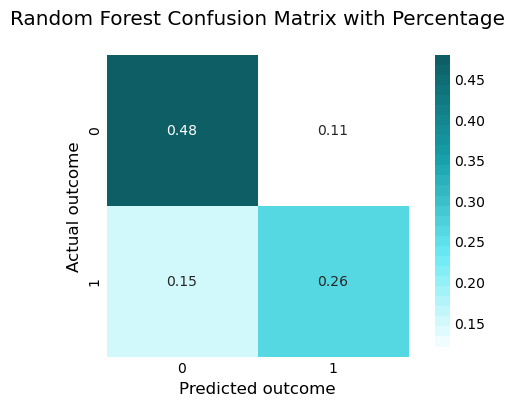

In [56]:
# Plot confusion matrix for random forest with percentage
colors = [(1, 1, 1), 
          ((106/256, 235/256, 245/256)), 
          ((22/256, 159/256, 169/256)), 
          ((14/256, 95/256, 101/256))] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=30)
rf_confusion = confusion_matrix(y_test_final, y_pred)
plt.figure(dpi=100)
ax = sns.heatmap(rf_confusion/np.sum(rf_confusion), cmap=cm, annot=True, square=True)

"""
0 = NBA rookie played 4 or fewer years in the league
1 = NBA rookie played more than 4 yrs
"""

ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

plt.xlabel('Predicted outcome')
plt.ylabel('Actual outcome')
plt.title('Random Forest Confusion Matrix with Percentage\n');

ROC AUC Score:  0.807


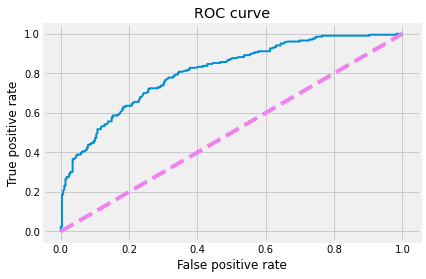

In [80]:
fpr, tpr, thresholds = roc_curve(y_test_final, final_model.predict_proba(X_test_final)[:,1])

plt.plot(fpr, tpr, lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

plt.savefig('ROC.jpg')

final_model_roc_auc_score =  roc_auc_score(y_test_final, final_model.predict_proba(X_test_final)[:,1])
print("ROC AUC Score: ", np.round(final_model_roc_auc_score, 3))

**The probability that the model will assign a larger probability to a random positive example than a random negative example is 0.807, which is commonly seen as a good value.  In other words, there is an 80.7% chance that the model will be able to distinguish between positive class and negative class.**

In [58]:
# Show feature importances
feat_importance_final = pd.DataFrame(final_model.feature_importances_, index=X_train_sel_feat_ros.columns, columns=['feature importance'])
feat_importance_final.sort_values(by='feature importance', ascending=False, inplace=True)
feat_importance_final

,feature importance
GP,0.123442
MIN,0.113761
PTS,0.105089
PF,0.099525
REB,0.094673
DREB,0.089062
+/-,0.080334
W,0.078269
OREB,0.076761
TOV,0.074122


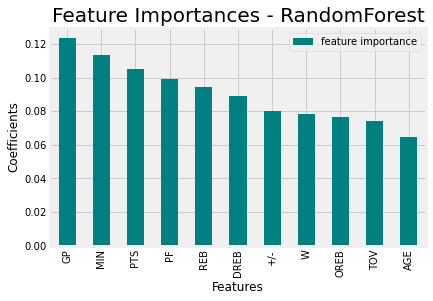

In [67]:
# Visualize feature importances
feat_importance_final.plot(kind='bar', color='teal') #figsize=(8,6))
plt.title('Feature Importances - RandomForest', size=20)
plt.xlabel('Features')
plt.ylabel('Coefficients')

plt.savefig('rf_final_feature_importances.jpg')

In [68]:
# Pickle Random Forest model for future use in app
import os
import pickle

with open('final_model.pickle', 'wb') as to_write:
    pickle.dump(final_model, to_write)